## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\Users\amonr\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\amonr\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\amonr\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\amonr\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layer' + str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layer' + str(i+1))(x)
            x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.99, 0.5, 0.1]
reduce_lr_patient = [3, 5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, reduce_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["acc"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor,
                                  min_lr=1e-12,
                                  monitor='val_loss',
                                  patience=reduce_patient,
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

Epoch 12/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.2950 - acc: 0.5486 - val_loss: 1.4806 - val_acc: 0.4787
Epoch 13/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2736 - acc: 0.5563 - val_loss: 1.4782 - val_acc: 0.4843
Epoch 14/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.2517 - acc: 0.5631 - val_loss: 1.4657 - val_acc: 0.4852
Epoch 15/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.2321 - acc: 0.5713 - val_loss: 1.4590 - val_acc: 0.4882
Epoch 16/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2125 - acc: 0.5804 - val_loss: 1.4641 - val_acc: 0.4890
Epoch 17/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.1929 - acc: 0.5830 - val_loss: 1.4630 - val_acc: 0.4924
Epoch 18/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.1742 - acc: 0.5913 - val_loss: 1.4507 - val_acc: 0.4934
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 87us/step - loss: 2.2367 - acc: 0.2687 - val_loss: 2.1580 - val_acc: 0.2055
Epoch 2/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.7627 - acc: 0.3842 - val_loss: 1.9821 - val_acc: 0.3030
Epoch 3/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.6343 - acc: 0.4288 - val_loss: 1.8310 - val_acc: 0.3707
Epoch 4/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.5586 - acc: 0.4528 - val_loss: 1.7186 - val_acc: 0.4064
Epoch 5/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.5037 - acc: 0.4746 - val_loss: 1.6458 - val_acc: 0.4279
Epoch 6/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.4579 - acc: 0.4900 - val_loss: 1.5841 - val_acc: 0.4412
Epoch 7/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.4212 - acc: 0.5040 - val_loss: 1.5472 - val_acc

50000/50000 [==============================] - 4s 72us/step - loss: 1.2391 - acc: 0.5720 - val_loss: 1.4972 - val_acc: 0.4777
Epoch 24/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2260 - acc: 0.5788 - val_loss: 1.4861 - val_acc: 0.4785
Epoch 25/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2151 - acc: 0.5830 - val_loss: 1.4883 - val_acc: 0.4793
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
____________________________________________________________

50000/50000 [==============================] - 4s 75us/step - loss: 1.4588 - acc: 0.4895 - val_loss: 1.5703 - val_acc: 0.4454
Epoch 11/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.4367 - acc: 0.4983 - val_loss: 1.5619 - val_acc: 0.4474
Epoch 12/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.4159 - acc: 0.5064 - val_loss: 1.5501 - val_acc: 0.4541
Epoch 13/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.3969 - acc: 0.5117 - val_loss: 1.5443 - val_acc: 0.4531
Epoch 14/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.3781 - acc: 0.5209 - val_loss: 1.5409 - val_acc: 0.4574
Epoch 15/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.3615 - acc: 0.5260 - val_loss: 1.5334 - val_acc: 0.4608
Epoch 16/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.3446 - acc: 0.5314 - val_loss: 1.5269 - val_acc: 0.4657
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 95us/step - loss: 2.3877 - acc: 0.2297 - val_loss: 2.1608 - val_acc: 0.2458
Epoch 2/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.8897 - acc: 0.3521 - val_loss: 2.0320 - val_acc: 0.2577
Epoch 3/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.7423 - acc: 0.3929 - val_loss: 1.9175 - val_acc: 0.3140
Epoch 4/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.6616 - acc: 0.4209 - val_loss: 1.8159 - val_acc: 0.3538
Epoch 5/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.6071 - acc: 0.4381 - val_loss: 1.7300 - val_acc: 0.3860
Epoch 6/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.5663 - acc: 0.4534 - val_loss: 1.6736 - val_acc: 0.4110
Epoch 7/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.5318 - acc: 0.4662 - val_loss: 1.6289 - val_acc

50000/50000 [==============================] - 4s 79us/step - loss: 0.5312 - acc: 0.8202 - val_loss: 1.7787 - val_acc: 0.4875
Epoch 22/25
50000/50000 [==============================] - 4s 79us/step - loss: 0.4900 - acc: 0.8360 - val_loss: 1.9330 - val_acc: 0.4688

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0009414802846731617.
Epoch 23/25
50000/50000 [==============================] - 4s 78us/step - loss: 0.4625 - acc: 0.8470 - val_loss: 2.0981 - val_acc: 0.4361
Epoch 24/25
50000/50000 [==============================] - 4s 78us/step - loss: 0.4407 - acc: 0.8535 - val_loss: 2.2349 - val_acc: 0.4420
Epoch 25/25
50000/50000 [==============================] - 4s 78us/step - loss: 0.4019 - acc: 0.8683 - val_loss: 2.0662 - val_acc: 0.4752

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0009320654743351042.
Numbers of exp: 10, reduce_factor: 0.99, reduce_patient: 5
Model: "model_11"
_________________________________________________________________
Layer (type)     

50000/50000 [==============================] - 4s 79us/step - loss: 1.2667 - acc: 0.5513 - val_loss: 1.7461 - val_acc: 0.3918
Epoch 7/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.2233 - acc: 0.5649 - val_loss: 1.6005 - val_acc: 0.4477
Epoch 8/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.1799 - acc: 0.5816 - val_loss: 1.5252 - val_acc: 0.4565
Epoch 9/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.1344 - acc: 0.5979 - val_loss: 1.5450 - val_acc: 0.4609
Epoch 10/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.0955 - acc: 0.6114 - val_loss: 1.4357 - val_acc: 0.4929
Epoch 11/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.0574 - acc: 0.6258 - val_loss: 1.5314 - val_acc: 0.4728
Epoch 12/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.0186 - acc: 0.6382 - val_loss: 1.4132 - val_acc: 0.5044
Epoch 13/25
50000/50000 [========================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.9007 - acc: 0.3545 - val_loss: 2.1477 - val_acc: 0.1715
Epoch 2/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.5545 - acc: 0.4553 - val_loss: 1.8995 - val_acc: 0.3254
Epoch 3/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.4520 - acc: 0.4913 - val_loss: 1.7286 - val_acc: 0.4049
Epoch 4/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.3831 - acc: 0.5163 - val_loss: 1.6064 - val_acc: 0.4383
Epoch 5/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.3329 - acc: 0.5351 - val_loss: 1.5349 - val_acc: 0.4673
Epoch 6/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.2911 - acc: 0.5495 - val_loss: 1.5027 - val_acc: 0.4698
Epoch 7/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.2511 - acc: 0.5655 - val_loss: 1.4750 - val_acc

50000/50000 [==============================] - 4s 83us/step - loss: 0.9066 - acc: 0.6975 - val_loss: 1.4092 - val_acc: 0.5121
Epoch 25/25
50000/50000 [==============================] - 4s 82us/step - loss: 0.8932 - acc: 0.7005 - val_loss: 1.4204 - val_acc: 0.5073

Epoch 00025: ReduceLROnPlateau reducing learning rate to 2.8261943953111768e-05.
Numbers of exp: 15, reduce_factor: 0.10, reduce_patient: 3
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)         

50000/50000 [==============================] - 4s 84us/step - loss: 1.8315 - acc: 0.3663 - val_loss: 1.8557 - val_acc: 0.3517
Epoch 11/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.8132 - acc: 0.3710 - val_loss: 1.8507 - val_acc: 0.3569
Epoch 12/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.7971 - acc: 0.3773 - val_loss: 1.8422 - val_acc: 0.3597
Epoch 13/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.7816 - acc: 0.3823 - val_loss: 1.8365 - val_acc: 0.3627
Epoch 14/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.7688 - acc: 0.3858 - val_loss: 1.8287 - val_acc: 0.3664
Epoch 15/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.7559 - acc: 0.3897 - val_loss: 1.8220 - val_acc: 0.3681
Epoch 16/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.7451 - acc: 0.3926 - val_loss: 1.8145 - val_acc: 0.3735
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.8471 - acc: 0.3650 - val_loss: 2.2355 - val_acc: 0.1914
Epoch 2/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.5428 - acc: 0.4552 - val_loss: 2.0998 - val_acc: 0.2881
Epoch 3/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.4263 - acc: 0.4949 - val_loss: 2.0612 - val_acc: 0.2953
Epoch 4/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.3453 - acc: 0.5254 - val_loss: 1.8063 - val_acc: 0.3839
Epoch 5/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.2840 - acc: 0.5478 - val_loss: 1.8023 - val_acc: 0.3684
Epoch 6/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.2280 - acc: 0.5666 - val_loss: 1.7500 - val_acc: 0.3916
Epoch 7/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.1767 - acc: 0.5857 - val_loss: 1.7596 - val_ac

50000/50000 [==============================] - 4s 82us/step - loss: 0.7029 - acc: 0.7557 - val_loss: 2.3317 - val_acc: 0.3898
Epoch 21/25
50000/50000 [==============================] - 4s 87us/step - loss: 0.6789 - acc: 0.7629 - val_loss: 1.9774 - val_acc: 0.4175
Epoch 22/25
50000/50000 [==============================] - 4s 89us/step - loss: 0.6499 - acc: 0.7747 - val_loss: 1.9959 - val_acc: 0.4203

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0009320654743351042.
Epoch 23/25
50000/50000 [==============================] - 4s 89us/step - loss: 0.6191 - acc: 0.7871 - val_loss: 1.9640 - val_acc: 0.4599
Epoch 24/25
50000/50000 [==============================] - 4s 89us/step - loss: 0.5905 - acc: 0.7975 - val_loss: 2.0052 - val_acc: 0.4448
Epoch 25/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.5657 - acc: 0.8047 - val_loss: 2.0052 - val_acc: 0.4459
Numbers of exp: 20, reduce_factor: 0.99, reduce_patient: 10
Model: "model_21"
_________________________

50000/50000 [==============================] - 4s 82us/step - loss: 1.2138 - acc: 0.5711 - val_loss: 1.8295 - val_acc: 0.3907

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004613724013324827.
Epoch 7/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.0910 - acc: 0.6202 - val_loss: 1.5502 - val_acc: 0.4581
Epoch 8/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.0450 - acc: 0.6365 - val_loss: 1.7211 - val_acc: 0.4184
Epoch 9/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.0076 - acc: 0.6502 - val_loss: 1.4876 - val_acc: 0.4771
Epoch 10/25
50000/50000 [==============================] - 4s 82us/step - loss: 0.9717 - acc: 0.6613 - val_loss: 1.5068 - val_acc: 0.4868
Epoch 11/25
50000/50000 [==============================] - 4s 90us/step - loss: 0.9407 - acc: 0.6748 - val_loss: 1.4690 - val_acc: 0.4918
Epoch 12/25
50000/50000 [==============================] - 4s 83us/step - loss: 0.9094 - acc: 0.6886 - val

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 102us/step - loss: 2.1413 - acc: 0.2878 - val_loss: 2.1964 - val_acc: 0.1740
Epoch 2/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.7851 - acc: 0.3826 - val_loss: 2.0327 - val_acc: 0.2972
Epoch 3/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.6584 - acc: 0.4235 - val_loss: 1.8776 - val_acc: 0.3699
Epoch 4/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.5721 - acc: 0.4529 - val_loss: 1.7418 - val_acc: 0.3987
Epoch 5/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.5114 - acc: 0.4742 - val_loss: 1.6357 - val_acc: 0.4268
Epoch 6/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.4612 - acc: 0.4928 - val_loss: 1.6008 - val_acc: 0.4386
Epoch 7/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.4201 - acc: 0.5078 - val_loss: 1.5564 - val_ac

50000/50000 [==============================] - 4s 83us/step - loss: 1.0454 - acc: 0.6448 - val_loss: 1.4846 - val_acc: 0.4872

Epoch 00024: ReduceLROnPlateau reducing learning rate to 5.767155016656034e-06.
Epoch 25/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.0048 - acc: 0.6635 - val_loss: 1.4258 - val_acc: 0.5021
Numbers of exp: 25, reduce_factor: 0.10, reduce_patient: 5
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_76 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)          

Epoch 11/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.8586 - acc: 0.3564 - val_loss: 1.8661 - val_acc: 0.3530
Epoch 12/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.8326 - acc: 0.3639 - val_loss: 1.8492 - val_acc: 0.3571
Epoch 13/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.8099 - acc: 0.3700 - val_loss: 1.8381 - val_acc: 0.3583
Epoch 14/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.7884 - acc: 0.3788 - val_loss: 1.8256 - val_acc: 0.3647
Epoch 15/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.7688 - acc: 0.3845 - val_loss: 1.8152 - val_acc: 0.3693
Epoch 16/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.7511 - acc: 0.3892 - val_loss: 1.8045 - val_acc: 0.3729
Epoch 17/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.7341 - acc: 0.3958 - val_loss: 1.7921 - val_acc: 0.3748
Epoch 18/25
50000/50000 [=========

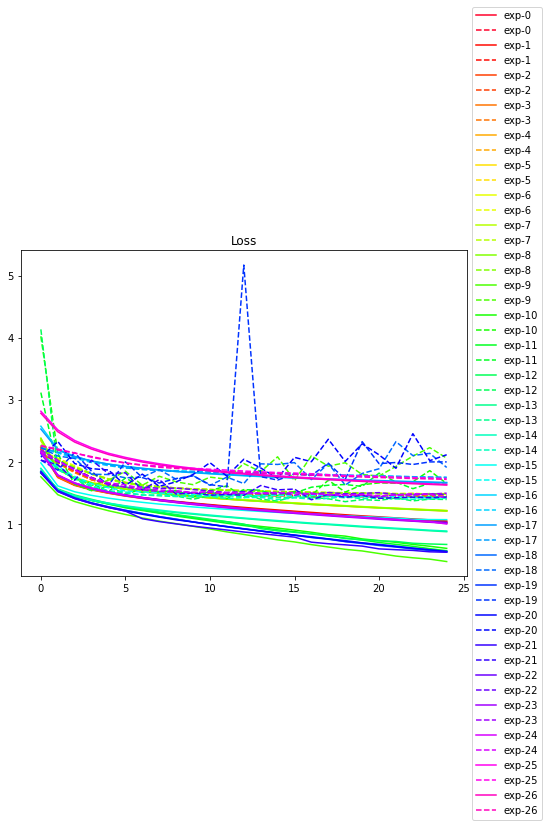

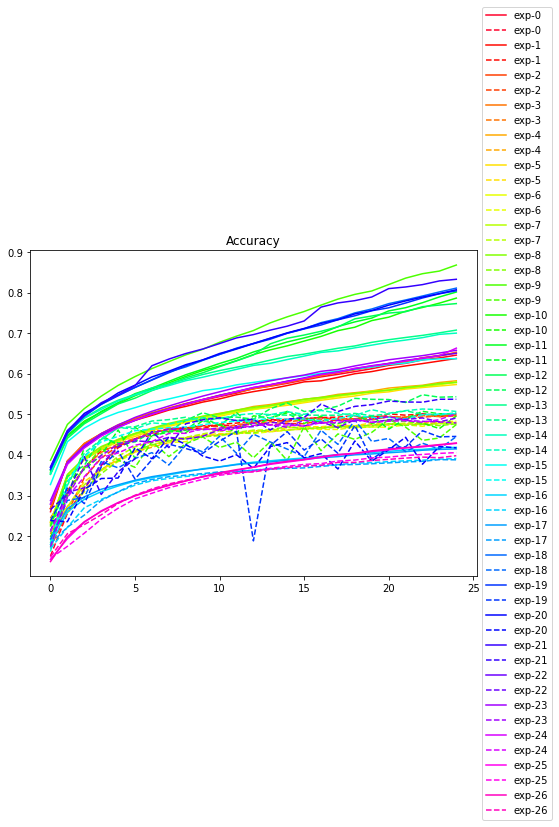

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()